In [139]:
import pandas as pd
import numpy as np
import geopandas as gpd
import plotly.express as px
import matplotlib.pyplot as plt
import tilemapbase
from shapely.geometry import MultiPolygon, Polygon

In [140]:
data = pd.read_csv('prepared_amsterdam_rent.csv')

In [141]:
yelp = pd.read_csv('./data/yelp_businesses.csv')

In [142]:
data.city.value_counts()

amsterdam                  15963
haarlem                     2193
amstelveen                  1317
hoofddorp                    809
zaandam                      804
diemen                       465
weesp                        387
heemstede                    290
zwanenburg                   283
nieuw-vennep                 278
aalsmeer                     234
badhoevedorp                 178
uithoorn                     174
ouderkerk-aan-de-amstel      111
bloemendaal                  106
duivendrecht                  60
Name: city, dtype: int64

In [143]:
#data = data[data['city']=='amsterdam']

In [144]:
data['pps'] = data['price']/data['surface']

In [145]:
ranks = {}
for t in data.type.unique():
    for pt in data.postType.unique():
        df = data[(data['type']==t)&(data['postType']==pt)]
        if len(df) > 0:
            ranks[(t,pt)] = df['pps'].rank()
            ranks[(t,pt)]=(ranks[(t,pt)]-ranks[(t,pt)].min())/(ranks[(t,pt)].max()-ranks[(t,pt)].min())

In [146]:
data['ppsRank'] = 0
for k in ranks:
    data.loc[ranks[k].index,'ppsRank'] = ranks[k]

In [147]:
buurten = gpd.read_file('./data/WijkBuurtkaart_2021_v1.gpkg',layer='cbs_buurten_2021')
wijken = gpd.read_file('./data/WijkBuurtkaart_2021_v1.gpkg',layer='cbs_wijken_2021')
gemeenten = gpd.read_file('./data/WijkBuurtkaart_2021_v1.gpkg',layer='gemeenten2021')

In [148]:
buurten = buurten.set_index(['gemeentecode','wijkcode']).join(wijken.set_index(['gemeentecode','wijkcode'])['wijknaam']).reset_index()

In [388]:
gdata = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude))
gdata = gdata.set_crs('EPSG:4326')

In [389]:
yelp = yelp[(yelp['latitude']>52.15)&(yelp['latitude']<52.5)&
    (yelp['longitude']>4.45)&(yelp['longitude']<5.2)]

In [390]:
gyelp = gpd.GeoDataFrame(yelp, geometry=gpd.points_from_xy(yelp.longitude, yelp.latitude))
gyelp = gyelp.set_crs('EPSG:4326')

In [391]:
buurten = buurten[['gemeentenaam','wijknaam','buurtnaam','geometry']].copy()
buurten['buurtnaam'] = buurten['buurtnaam'].str.strip().replace('',np.nan)
buurten = buurten.dropna()
buurten = buurten.to_crs('EPSG:4326')

In [392]:
wijken = wijken[['gemeentenaam','wijknaam','geometry']].copy()
wijken['wijknaam'] = wijken['wijknaam'].str.strip().replace('',np.nan)
wijken = wijken.dropna()
wijken = wijken.to_crs('EPSG:4326')

In [393]:
gemeenten = gemeenten[['gemeentenaam','geometry']].copy()
gemeenten['gemeentenaam'] = gemeenten['gemeentenaam'].str.strip().replace('',np.nan)
gemeenten = gemeenten.dropna()
gemeenten = gemeenten.to_crs('EPSG:4326')

In [394]:
#gdata = gpd.sjoin(gdata, gemeenten, predicate='within').drop(columns='index_right')
#gdata = gpd.sjoin(gdata, wijken, predicate='within').drop(columns='index_right')
gdata = gpd.sjoin(gdata, buurten, predicate='within').drop(columns='index_right')

In [395]:
gdata['ppsRank'] = gdata['ppsRank'].astype('float')

In [396]:
colormap = {}
colors = ['#F0E68C','#40E0D0','#FAF0E6','#8B0000','#8B008B',
         '#808080','#E0FFFF','#FF6347','#FFDAB9','#B22222',
         '#00008B','#87CEEB','#FF00FF','#00FA9A','#D3D3D3',
         '#D2B48C','#191970','#BDB76B','#F0F8FF','#FFE4E1',
         '#7FFFD4']

cats = gyelp.category.unique()
for i in range(len(colors)):
    colormap[cats[i]] = colors[i]

In [397]:
gyelp['color'] = gyelp['category'].map(colormap)

In [398]:
gdata

,source,city,postcode,type,price,surface,rooms,latitude,longitude,postType,pps,ppsRank,geometry,gemeentenaam,wijknaam,buurtnaam
0,kamernet,amsterdam,1103SE,apartment,3120.0,120.0,3.0,52.322157,4.981185,Rent,26.000000,0.611282,POINT (4.98118 52.32216),Amsterdam,"Bijlmer Oost (E,G,K)",Grunder/Koningshoef
6,kamernet,amsterdam,1103SC,room,700.0,18.0,1.0,52.323582,4.978148,Rent,38.888889,0.336085,POINT (4.97815 52.32358),Amsterdam,"Bijlmer Oost (E,G,K)",Grunder/Koningshoef
1547,pararius,amsterdam,1104DB,apartment,1250.0,35.0,2.0,52.320275,4.981223,Rent,35.714286,0.914892,POINT (4.98122 52.32028),Amsterdam,"Bijlmer Oost (E,G,K)",Grunder/Koningshoef
3256,pararius,amsterdam,1104DC,apartment,42500.0,90.0,4.0,52.320055,4.982128,Buy,472.222222,0.044012,POINT (4.98213 52.32006),Amsterdam,"Bijlmer Oost (E,G,K)",Grunder/Koningshoef
5017,funda,amsterdam,1103SE,house,495000.0,117.0,5.0,52.322157,4.981185,Buy,4230.769231,0.401506,POINT (4.98118 52.32216),Amsterdam,"Bijlmer Oost (E,G,K)",Grunder/Koningshoef
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19794,kamernet,amsterdam,1014BV,studio,368.0,20.0,1.0,52.396003,4.850208,Rent,18.400000,0.065015,POINT (4.85021 52.39600),Amsterdam,Westelijk Havengebied,Alfa-driehoek
19952,kamernet,amsterdam,1095KX,studio,600.0,38.0,2.0,52.369815,4.965826,Rent,15.789474,0.026316,POINT (4.96583 52.36982),Amsterdam,Zeeburgereiland/Nieuwe Diep,Zeeburgereiland Zuidoost
22909,pararius,amsterdam,1096CR,house,1300000.0,141.0,5.0,52.329660,4.902655,Buy,9219.858156,0.960894,POINT (4.90265 52.32966),Amsterdam,Omval/Overamstel,Overamstel
22953,pararius,amsterdam,1096CR,house,685000.0,110.0,5.0,52.329660,4.902655,Buy,6227.272727,0.752975,POINT (4.90265 52.32966),Amsterdam,Omval/Overamstel,Overamstel


<AxesSubplot:>

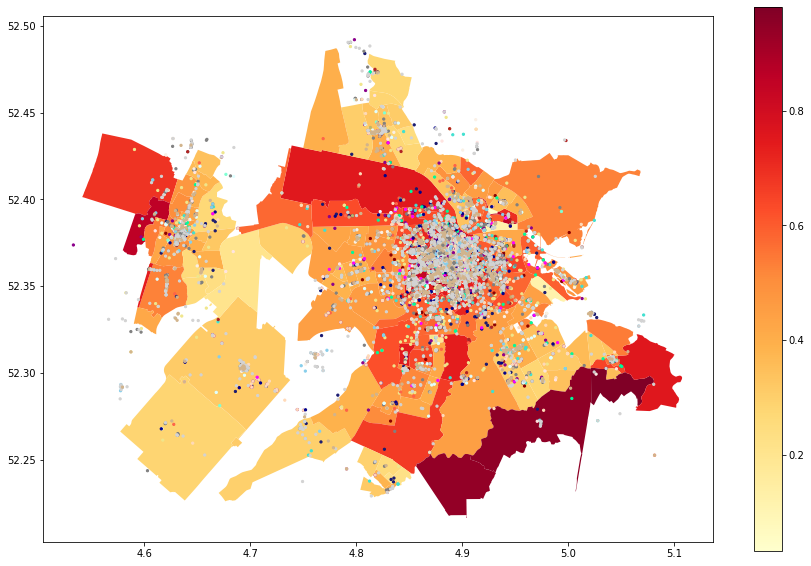

In [399]:
fig, ax = plt.subplots(figsize=(15, 10))
wijken.set_index(['wijknaam','gemeentenaam']).join(gdata.groupby(['wijknaam','gemeentenaam'])['ppsRank'].median(),how='inner').plot(column='ppsRank',cmap='YlOrRd',legend=True,ax=ax)
gyelp.plot(ax=ax,markersize=5,color=gyelp['color'])

<AxesSubplot:>

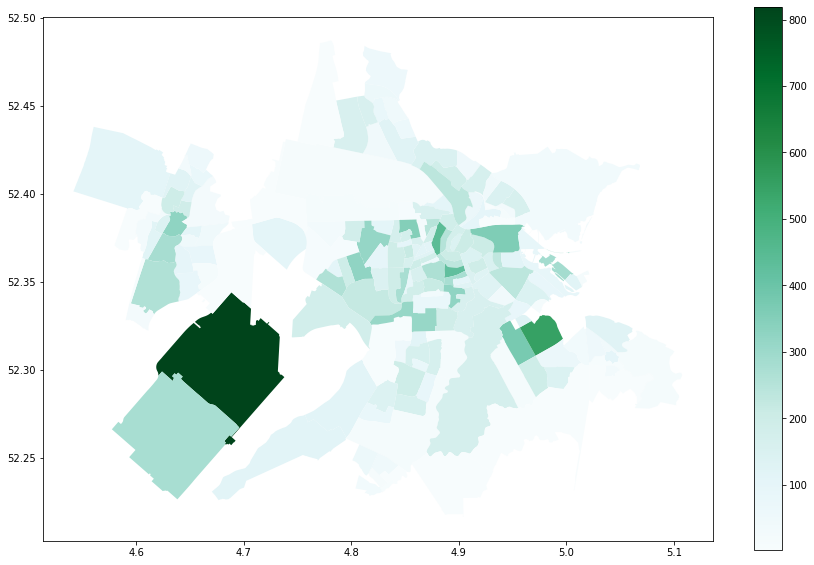

In [400]:
wijken.set_index(['wijknaam','gemeentenaam']).join(gdata.groupby(['wijknaam','gemeentenaam'])['ppsRank'].count(),how='inner').plot(column='ppsRank',cmap='BuGn',figsize=(15, 10),legend=True)

<AxesSubplot:>

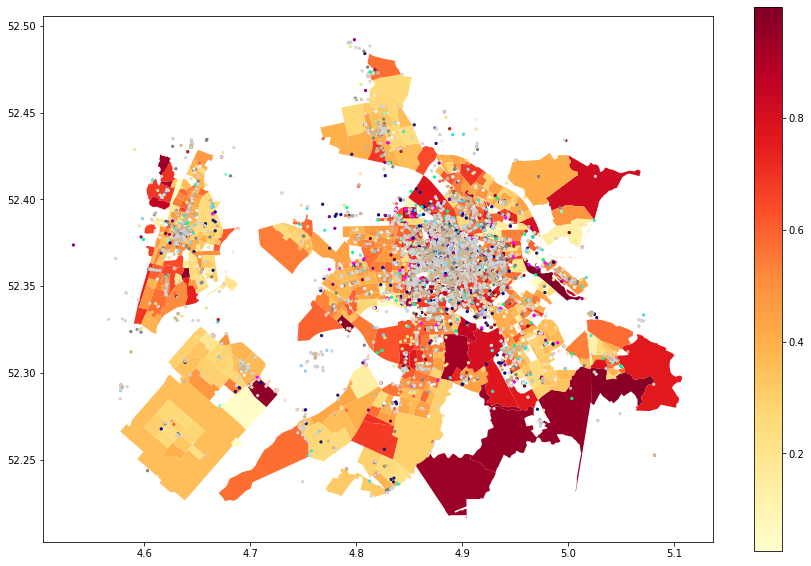

In [401]:
fig, ax = plt.subplots(figsize=(15, 10))
buurten.set_index(['buurtnaam','gemeentenaam']).join(gdata.groupby(['buurtnaam','gemeentenaam'])['ppsRank'].median(),how='inner').plot(column='ppsRank',cmap='YlOrRd',ax=ax,legend=True)
gyelp.plot(ax=ax,markersize=5,color=gyelp['color'])

In [402]:
count = (gdata.groupby(['gemeentenaam','wijknaam','buurtnaam']).count()[['source']]
         .reset_index().set_index(['gemeentenaam','wijknaam']).join(
         gdata.groupby(['gemeentenaam','wijknaam']).count()[['geometry']]))

In [403]:
count = count.rename(columns={
    'source': 'buurt_count',
    'geometry': 'wijk_count'
})

In [404]:
count = count.reset_index()

In [405]:
geometry = count[count['buurt_count']>=15].set_index(['gemeentenaam','wijknaam','buurtnaam'])[[]].join(buurten.set_index(['gemeentenaam','wijknaam','buurtnaam'])).reset_index()

In [406]:
count[count['buurt_count']<15]

,gemeentenaam,wijknaam,buurtnaam,buurt_count,wijk_count
7,Aalsmeer,Wijk 02 Oosteinde,Schinkelpolder,2,117
8,Amstelveen,Amsterdamse Bos,Amsterdamse Bos Noord,5,5
15,Amstelveen,Bovenkerk - Westwijk Noord,Buitenplaatsenbuurt,7,139
18,Amstelveen,Buitengebied Noord,Buurt over Ouderkerk,12,21
19,Amstelveen,Buitengebied Noord,Middelpolder,9,21
...,...,...,...,...,...
691,Zaanstad,Wijk 16 Zaandam Noord,Zaanse Schans,4,61
692,Zaanstad,Wijk 21 Oude Haven,Havenbuurt,2,45
693,Zaanstad,Wijk 21 Oude Haven,Het Eiland,10,45
695,Zaanstad,Wijk 21 Oude Haven,Zuiderhout,1,45


In [418]:
def compute_count(props):
    count = (props.groupby(['gemeentenaam','wijknaam','buurtnaam']).count()[['source']]
                 .reset_index().set_index(['gemeentenaam','wijknaam']).join(
                 props.groupby(['gemeentenaam','wijknaam']).count()[['geometry']]))
    count = count.rename(columns={
                        'source': 'buurt_count',
                        'geometry': 'wijk_count'})
    count = count.reset_index()
    return count

def find_populated_regions(props,buurten,wijken,count_threshold=15):
    no_useful_neighs = pd.DataFrame()
    print('INTRAWIJK')
    while True:
        count = compute_count(props)

        few_props = count[(count['buurt_count']<count_threshold)&(count['wijk_count']>=count_threshold)]
        if len(few_props) != 0:
            row = few_props.iloc[0]
            gem = row['gemeentenaam']
            wik = row['wijknaam']
            brt = row['buurtnaam']
            same_wijk_count = count[(count['gemeentenaam']==gem)&(count['wijknaam']==wik)]
            neighbuurts = gpd.sjoin(buurten[(buurten['gemeentenaam']==gem)&(buurten['wijknaam']==wik)&(buurten['buurtnaam']==brt)], 
                                    buurten[(buurten['gemeentenaam']== gem)&(buurten['wijknaam']==wik)], predicate='intersects')[['gemeentenaam_left','wijknaam_left','buurtnaam_right']]
            neighbuurts.columns = ['gemeentenaam','wijknaam','buurtnaam']
            neighbuurts = neighbuurts[neighbuurts['buurtnaam']!=brt]
            indexes = neighbuurts.set_index(['gemeentenaam','wijknaam','buurtnaam']).join(same_wijk_count.set_index(['gemeentenaam','wijknaam','buurtnaam']))['buurt_count'].sort_values().index
            if len(indexes) != 0:
                brt_tojoin = indexes[0][2]
            else:
                print(f'Failed to find neighbour buurt for {brt}')
                no_useful_neighs =  pd.concat([no_useful_neighs,props[(props['gemeentenaam']==gem)&
                                                                     (props['wijknaam']==wik)&
                                                                     (props['buurtnaam']==brt)]])
                props = props[~((props['gemeentenaam']==gem)&
                            (props['wijknaam']==wik)&
                            (props['buurtnaam']==brt))].reset_index(drop=True)
                continue 
                
            jburt = brt_tojoin+' & '+brt

            print(jburt)
            
            try:
                united_geometry = MultiPolygon(buurten[(buurten['gemeentenaam']==gem)&
                                   (buurten['wijknaam']==wik)&
                                   (buurten['buurtnaam']==brt)]['geometry'].values[0]).union(MultiPolygon(buurten[(buurten['gemeentenaam']==gem)&
                                   (buurten['wijknaam']==wik)&
                                   (buurten['buurtnaam']==brt_tojoin)]['geometry'].values[0]))

            except:
                h1 = buurten[(buurten['gemeentenaam']==gem)&
                            (buurten['wijknaam']==wik)&
                            (buurten['buurtnaam']==brt)]['geometry'].values
                h2 = buurten[(buurten['gemeentenaam']==gem)&
                            (buurten['wijknaam']==wik)&
                            (buurten['buurtnaam']==brt_tojoin)]['geometry'].values
                seq1 = []
                for pol in h1:
                    seq1.extend([i for i in pol.geoms])
                mp1 = MultiPolygon(seq1)
                seq2 = []
                for pol in h2:
                    seq2.extend([i for i in pol.geoms])
                mp2 = MultiPolygon(seq2)
                united_geometry = mpi.union(mp2)


            union_data = {'gemeentenaam':[gem],
                     'wijknaam':[wik],
                     'buurtnaam':[jburt],
                     'geometry':[united_geometry]}

            buurten = buurten.drop(index=buurten[(buurten['gemeentenaam']==gem)&(buurten['wijknaam']==wik)&(buurten['buurtnaam']==brt)].index[0]).reset_index(drop=True)
            buurten = buurten.drop(index=buurten[(buurten['gemeentenaam']==gem)&(buurten['wijknaam']==wik)&(buurten['buurtnaam']==brt_tojoin)].index[0]).reset_index(drop=True)

            buurten = gpd.GeoDataFrame(pd.concat([buurten,gpd.GeoDataFrame(union_data)]).reset_index(drop=True))
            #print(type(buurten))
            
            props.loc[(props['gemeentenaam']==gem)&
                     (props['wijknaam']==wik)&
                     (props['buurtnaam']==brt), 'buurtnaam'] = jburt
            props.loc[(props['gemeentenaam']==gem)&
                     (props['wijknaam']==wik)&
                     (props['buurtnaam']==brt_tojoin), 'buurtnaam'] = jburt

        else:
            break
            
    props = pd.concat([props,no_useful_neighs])
    no_useful_neighs = pd.DataFrame()

    props = pd.concat([props,no_useful_neighs])
    print('----')
    print('INTERWIJK')
    while True:
        count = compute_count(props)

        few_props = count[(count['buurt_count']<count_threshold)]
        if len(few_props) != 0:
            row = few_props.iloc[0]
            gem = row['gemeentenaam']
            wik = row['wijknaam']
            brt = row['buurtnaam']
            neighbuurts = gpd.sjoin(buurten[(buurten['gemeentenaam']==gem)&(buurten['wijknaam']==wik)&(buurten['buurtnaam']==brt)], 
                                    buurten[(buurten['gemeentenaam']== gem)], predicate='intersects')[['gemeentenaam_left','wijknaam_right','buurtnaam_right']]
            neighbuurts.columns = ['gemeentenaam','wijknaam','buurtnaam']
            neighbuurts = neighbuurts[neighbuurts['buurtnaam']!=brt]
            
            indexes = neighbuurts.set_index(['gemeentenaam','wijknaam','buurtnaam']).join(count.set_index(['gemeentenaam','wijknaam','buurtnaam']))['buurt_count'].sort_values().index
            if len(indexes) != 0:
                wik_tojoin = indexes[0][1]
                brt_tojoin = indexes[0][2]
            else:
                print(f'Failed to find neighbour buurt for {brt}')
                no_useful_neighs =  pd.concat([no_useful_neighs,props[(props['gemeentenaam']==gem)&
                                                                     (props['wijknaam']==wik)&
                                                                     (props['buurtnaam']==brt)]])
                props = props[~((props['gemeentenaam']==gem)&
                            (props['wijknaam']==wik)&
                            (props['buurtnaam']==brt))].reset_index(drop=True)
                continue 
                
            jburt = brt_tojoin+' & '+brt
            jwik = wik_tojoin+' & '+wik

            print(jburt)
            
            try:
                united_geometry = MultiPolygon(buurten[(buurten['gemeentenaam']==gem)&
                               (buurten['wijknaam']==wik)&
                               (buurten['buurtnaam']==brt)]['geometry'].values.union(buurten[(buurten['gemeentenaam']==gem)&
                               (buurten['wijknaam']==wik_tojoin)&
                               (buurten['buurtnaam']==brt_tojoin)]['geometry'].values))
            except:
                h = buurten[(buurten['gemeentenaam']==gem)&
                            (buurten['wijknaam']==wik)&
                            (buurten['buurtnaam']==brt)]['geometry'].values.union(buurten[(buurten['gemeentenaam']==gem)&
                            (buurten['wijknaam']==wik_tojoin)&
                            (buurten['buurtnaam']==brt_tojoin)]['geometry'].values)
                seq = []
                for pol in h:
                    seq.extend([i for i in pol.geoms])
                united_geometry = MultiPolygon(seq)

            union_data = {'gemeentenaam':[gem],
                     'wijknaam':[jwik],
                     'buurtnaam':[jburt],
                     'geometry':[united_geometry]}

            buurten = buurten.drop(index=buurten[(buurten['gemeentenaam']==gem)&(buurten['wijknaam']==wik)&(buurten['buurtnaam']==brt)].index[0]).reset_index(drop=True)
            buurten = buurten.drop(index=buurten[(buurten['gemeentenaam']==gem)&(buurten['wijknaam']==wik_tojoin)&(buurten['buurtnaam']==brt_tojoin)].index[0]).reset_index(drop=True)

            buurten = gpd.GeoDataFrame(pd.concat([buurten,gpd.GeoDataFrame(union_data)]).reset_index(drop=True))
            
            props.loc[(props['gemeentenaam']==gem)&
                     (props['wijknaam']==wik)&
                     (props['buurtnaam']==brt), 'buurtnaam'] = jburt
            props.loc[(props['gemeentenaam']==gem)&
                     (props['wijknaam']==wik)&
                     (props['buurtnaam']==brt), 'wijknaam'] = jwik
            
            props.loc[(props['gemeentenaam']==gem)&
                     (props['wijknaam']==wik_tojoin)&
                     (props['buurtnaam']==brt_tojoin), 'buurtnaam'] = jburt
            props.loc[(props['gemeentenaam']==gem)&
                     (props['wijknaam']==wik_tojoin)&
                     (props['buurtnaam']==brt_tojoin), 'wijknaam'] = jwik
        else:
            break
            
    props = pd.concat([props,no_useful_neighs])
    no_useful_neighs = pd.DataFrame()
    
    props = pd.concat([props,no_useful_neighs])
    print('----')
    print('INTEGEEM')
    while True:
        count = compute_count(props)

        few_props = count[(count['buurt_count']<count_threshold)]
        if len(few_props) != 0:
            row = few_props.iloc[0]
            gem = row['gemeentenaam']
            wik = row['wijknaam']
            brt = row['buurtnaam']
            neighbuurts = gpd.sjoin(buurten[(buurten['gemeentenaam']==gem)&(buurten['wijknaam']==wik)&(buurten['buurtnaam']==brt)], 
                                    buurten, predicate='intersects')[['gemeentenaam_right','wijknaam_right','buurtnaam_right']]
            neighbuurts.columns = ['gemeentenaam','wijknaam','buurtnaam']
            neighbuurts = neighbuurts[neighbuurts['buurtnaam']!=brt]
            
            indexes = neighbuurts.set_index(['gemeentenaam','wijknaam','buurtnaam']).join(count.set_index(['gemeentenaam','wijknaam','buurtnaam']))['buurt_count'].sort_values().index
            if len(indexes) != 0:
                gem_tojoin = indexes[0][0]
                wik_tojoin = indexes[0][1]
                brt_tojoin = indexes[0][2]
            else:
                print(f'Failed to find neighbour buurt for {brt}')
                no_useful_neighs =  pd.concat([no_useful_neighs,props[(props['gemeentenaam']==gem)&
                                                                     (props['wijknaam']==wik)&
                                                                     (props['buurtnaam']==brt)]])
                props = props[~((props['gemeentenaam']==gem)&
                            (props['wijknaam']==wik)&
                            (props['buurtnaam']==brt))].reset_index(drop=True)
                continue 
                
            jgem = gem_tojoin+' & '+gem
            jburt = brt_tojoin+' & '+brt
            jwik = wik_tojoin+' & '+wik

            print(jburt)
            
            try:
                united_geometry = MultiPolygon(buurten[(buurten['gemeentenaam']==gem)&
                               (buurten['wijknaam']==wik)&
                               (buurten['buurtnaam']==brt)]['geometry'].values.union(buurten[(buurten['gemeentenaam']==gem_tojoin)&
                               (buurten['wijknaam']==wik_tojoin)&
                               (buurten['buurtnaam']==brt_tojoin)]['geometry'].values))
            except:
                h = buurten[(buurten['gemeentenaam']==gem)&
                            (buurten['wijknaam']==wik)&
                            (buurten['buurtnaam']==brt)]['geometry'].values.union(buurten[(buurten['gemeentenaam']==gem_tojoin)&
                            (buurten['wijknaam']==wik_tojoin)&
                            (buurten['buurtnaam']==brt_tojoin)]['geometry'].values)
                seq = []
                for pol in h:
                    seq.extend([i for i in pol.geoms])
                united_geometry = MultiPolygon(seq)

            union_data = {'gemeentenaam':[jgem],
                     'wijknaam':[jwik],
                     'buurtnaam':[jburt],
                     'geometry':[united_geometry]}

            buurten = buurten.drop(index=buurten[(buurten['gemeentenaam']==gem)&(buurten['wijknaam']==wik)&(buurten['buurtnaam']==brt)].index[0]).reset_index(drop=True)
            buurten = buurten.drop(index=buurten[(buurten['gemeentenaam']==gem_tojoin)&(buurten['wijknaam']==wik_tojoin)&(buurten['buurtnaam']==brt_tojoin)].index[0]).reset_index(drop=True)

            buurten = gpd.GeoDataFrame(pd.concat([buurten,gpd.GeoDataFrame(union_data)]).reset_index(drop=True))
            
            props.loc[(props['gemeentenaam']==gem)&
                     (props['wijknaam']==wik)&
                     (props['buurtnaam']==brt), 'gemeentenaam'] = jgem
            props.loc[(props['gemeentenaam']==gem)&
                     (props['wijknaam']==wik)&
                     (props['buurtnaam']==brt), 'buurtnaam'] = jburt
            props.loc[(props['gemeentenaam']==gem)&
                     (props['wijknaam']==wik)&
                     (props['buurtnaam']==brt), 'wijknaam'] = jwik
            
            props.loc[(props['gemeentenaam']==gem_tojoin)&
                     (props['wijknaam']==wik_tojoin)&
                     (props['buurtnaam']==brt_tojoin), 'gemeentenaam'] = jgem
            props.loc[(props['gemeentenaam']==gem_tojoin)&
                     (props['wijknaam']==wik_tojoin)&
                     (props['buurtnaam']==brt_tojoin), 'buurtnaam'] = jburt
            props.loc[(props['gemeentenaam']==gem_tojoin)&
                     (props['wijknaam']==wik_tojoin)&
                     (props['buurtnaam']==brt_tojoin), 'wijknaam'] = jwik
        else:
            break
    
    print(f'Number of properties not appendable to region big enough: {len(no_useful_neighs)}')
    props = pd.concat([props,no_useful_neighs])
    count = compute_count(props)
    geometry = count.set_index(['gemeentenaam','wijknaam','buurtnaam'])[[]].join(buurten.set_index(['gemeentenaam','wijknaam','buurtnaam'])).reset_index()
    geometry = gpd.GeoDataFrame(geometry)
    
    return props, geometry, no_useful_neighs





In [419]:
props, geometry, no_useful_neighs = find_populated_regions(props=gdata.copy(),wijken=wijken.copy(),buurten=buurten.copy(),count_threshold=15)

INTRAWIJK
Bovenlanden & Schinkelpolder
Landschappenbuurt & Buitenplaatsenbuurt
Middelpolder & Buurt over Ouderkerk
Nes aan de Amstel & Legmeerpolder
Langerhuize & Alpen Rondwegbuurt
Kastanjebuurt & Oude Dorp
Augustinuspark & Startbaanbuurt
Kruidenbuurt & De Scheg
Amstel III deel A/B Zuid & Amstel III deel A/B Noord
AMC & Hoge Dijk
Amstel III deel A/B Zuid & Amstel III deel A/B Noord & AMC & Hoge Dijk


AttributeError: 'Polygon' object has no attribute 'geoms'

In [409]:
geometry

,gemeentenaam,wijknaam,buurtnaam,geometry
0,Aalsmeer,Wijk 00 Aalsmeer,Centrum,"MULTIPOLYGON (((4.75718 52.27399, 4.75718 52.2..."
1,Aalsmeer,Wijk 00 Aalsmeer,Hornmeer,"MULTIPOLYGON (((4.78953 52.26785, 4.78965 52.2..."
2,Aalsmeer,Wijk 00 Aalsmeer,Stommeer,"MULTIPOLYGON (((4.76498 52.27179, 4.76508 52.2..."
3,Aalsmeer,Wijk 00 Aalsmeer,Uiterweg,"MULTIPOLYGON (((4.74420 52.26939, 4.74536 52.2..."
4,Aalsmeer,Wijk 02 Oosteinde,Bovenlanden & Schinkelpolder,"MULTIPOLYGON (((4.81045 52.30530, 4.81063 52.3..."
...,...,...,...,...
546,Zaanstad,Wijk 22 Zaandam West,Schilders- en Waddenbuurt,"MULTIPOLYGON (((4.81260 52.45491, 4.81379 52.4..."
547,Zaanstad,Wijk 22 Zaandam West,Spoorbuurt,"MULTIPOLYGON (((4.81190 52.44891, 4.81234 52.4..."
548,Zaanstad,Wijk 23 Nieuw West,Westerspoor & Westzaan Zuid,None
549,Zaanstad,Wijk 23 Nieuw West,Westerwatering,"MULTIPOLYGON (((4.80588 52.45373, 4.80602 52.4..."


In [380]:
geometry = gpd.GeoDataFrame(geometry)

In [381]:
gdata = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude))
gdata = gdata.set_crs('EPSG:4326')
gdata = gpd.sjoin(gdata, geometry, predicate='within').drop(columns='index_right')
gdata['ppsRank'] = gdata['ppsRank'].astype('float')

<AxesSubplot:>

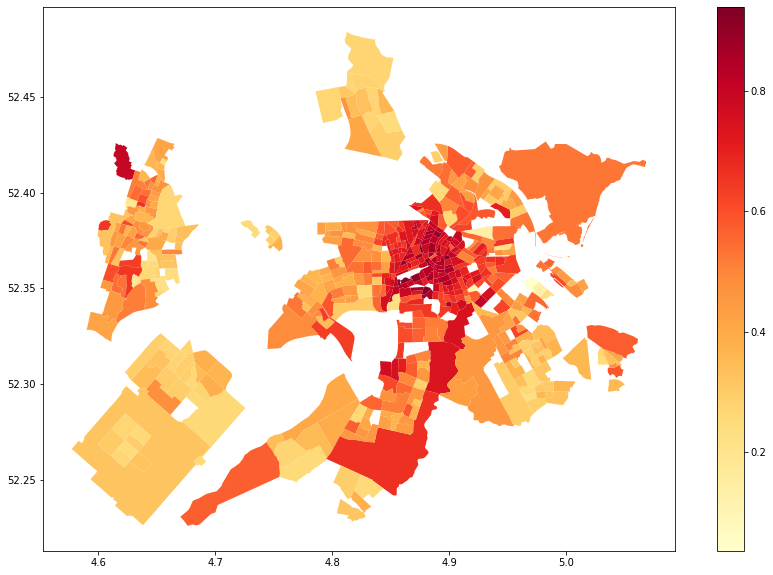

In [382]:
fig, ax = plt.subplots(figsize=(15, 10))
geometry.set_index(['gemeentenaam','wijknaam','buurtnaam']).join(gdata.groupby(['gemeentenaam','wijknaam','buurtnaam'])['ppsRank'].median(),how='inner').plot(column='ppsRank',cmap='YlOrRd',legend=True,ax=ax)
#gyelp.plot(ax=ax,markersize=5,color=gyelp['color'])

<AxesSubplot:>

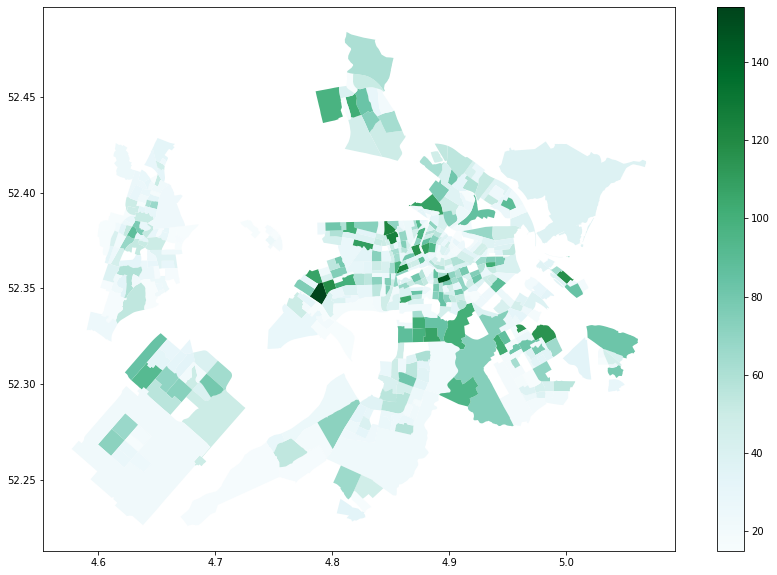

In [383]:
fig, ax = plt.subplots(figsize=(15, 10))
geometry.set_index(['gemeentenaam','wijknaam','buurtnaam']).join(gdata.groupby(['gemeentenaam','wijknaam','buurtnaam'])['ppsRank'].count(),how='inner').plot(column='ppsRank',cmap='BuGn',legend=True,ax=ax)
#gyelp.plot(ax=ax,markersize=5,color=gyelp['color'])

In [384]:
gdata.groupby(['gemeentenaam','wijknaam','buurtnaam'])[['ppsRank']].count().sort_values('ppsRank')

ppsRank
gemeentenaam   wijknaam                  buurtnaam                     
Amsterdam      Osdorp-Oost               Calandlaan/Lelylaan         15
               Nieuwmarkt/Lastage        Oosterdokseiland            15
Zaanstad       Wijk 15 Kogerveldwijk     Boerejonkerbuurt            15
Amsterdam      Holendrecht/Reigersbos    Holendrecht Oost            15
Haarlemmermeer Zwanenburg                Zwanenburg Noordoost        15
...                                                                 ...
Amsterdam      Landlust                  Bosleeuw                   122
               Overtoomse Sluis          Cremerbuurt West           124
               Erasmuspark               Erasmusparkbuurt West      125
               Oude Pijp                 Sarphatiparkbuurt          146
               Middelveldsche Akerpolder De Aker Oost               154

[515 rows x 1 columns]

In [385]:
gdata[(gdata['gemeentenaam']=='Zaanstad')&(gdata['wijknaam'].isin(['Wijk 23 Nieuw West','Wijk 81 Westzaan']))]

,source,city,postcode,type,price,surface,rooms,latitude,longitude,postType,pps,ppsRank,geometry,gemeentenaam,wijknaam,buurtnaam
224,kamernet,zaandam,1507XA,room,600.0,11.0,1.0,52.449729,4.798628,Rent,54.545455,0.664611,POINT (4.79863 52.44973),Zaanstad,Wijk 23 Nieuw West,Westerwatering
1177,funda,zaandam,1507WH,house,1577.0,133.0,5.0,52.449065,4.800261,Rent,11.857143,0.031785,POINT (4.80026 52.44907),Zaanstad,Wijk 23 Nieuw West,Westerwatering
2115,pararius,zaandam,1507RX,house,3500.0,237.0,6.0,52.447243,4.798799,Rent,14.767932,0.132029,POINT (4.79880 52.44724),Zaanstad,Wijk 23 Nieuw West,Westerwatering
4213,pararius,zaandam,1507TC,house,56000.0,160.0,6.0,52.439545,4.806954,Buy,350.000000,0.018217,POINT (4.80695 52.43955),Zaanstad,Wijk 23 Nieuw West,Westerwatering
4216,pararius,zaandam,1507JD,house,40000.0,99.0,6.0,52.446556,4.805222,Buy,404.040404,0.050279,POINT (4.80522 52.44656),Zaanstad,Wijk 23 Nieuw West,Westerwatering
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21428,kamernet,zaandam,1507JK,room,500.0,6.0,1.0,52.446133,4.805670,Rent,83.333333,0.939924,POINT (4.80567 52.44613),Zaanstad,Wijk 23 Nieuw West,Westerwatering
21976,kamernet,zaandam,1507SP,room,550.0,10.0,4.0,52.446737,4.799677,Rent,55.000000,0.673762,POINT (4.79968 52.44674),Zaanstad,Wijk 23 Nieuw West,Westerwatering
21991,kamernet,zaandam,1507SN,room,550.0,13.0,1.0,52.445977,4.799810,Rent,42.307692,0.414263,POINT (4.79981 52.44598),Zaanstad,Wijk 23 Nieuw West,Westerwatering
22140,kamernet,zaandam,1507XN,room,550.0,10.0,1.0,52.452535,4.797472,Rent,55.000000,0.673762,POINT (4.79747 52.45254),Zaanstad,Wijk 23 Nieuw West,Westerwatering
